<a href="https://colab.research.google.com/github/andryelarossignol/LBP_extractor/blob/main/LBP_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle opencv-python-headless scikit-learn matplotlib

In [ ]:
import kagglehub

path = kagglehub.dataset_download("phattanunthabarsa/kylberg-texture-dataset")

print("Path to dataset files:", path)

100%|██████████| 901M/901M [00:41<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/phattanunthabarsa/kylberg-texture-dataset/versions/1


In [ ]:
# Verificando o caminho onde os dados foram baixados
print(path)


/root/.cache/kagglehub/datasets/phattanunthabarsa/kylberg-texture-dataset/versions/1


In [ ]:
import os

# Listando o conteúdo do dataset
!ls {path}


blanket1-without-rotations  linseeds1-without-rotations    seat1-without-rotations
blanket2-without-rotations  oatmeal1-without-rotations	   seat2-without-rotations
canvas1-without-rotations   pearlsugar1-without-rotations  sesameseeds1-without-rotations
ceiling1-without-rotations  rice1-without-rotations	   stone1-without-rotations
ceiling2-without-rotations  rice2-without-rotations	   stone2-without-rotations
cushion1-without-rotations  rug1-without-rotations	   stone3-without-rotations
floor1-without-rotations    sand1-without-rotations	   stoneslab1-without-rotations
floor2-without-rotations    scarf1-without-rotations	   wall1-without-rotations
grass1-without-rotations    scarf2-without-rotations
lentils1-without-rotations  screen1-without-rotations


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern


In [ ]:
def load_images(dataset_path):
    selected_classes = [
        'blanket1-without-rotations',
        'ceiling2-without-rotations',
        'floor1-without-rotations',
        'rice2-without-rotations',
        'scarf1-without-rotations',
    ]
    data, labels = [], []
    for label in os.listdir(dataset_path):
        if label in selected_classes:
            folder_path = os.path.join(dataset_path, label)
            for file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (128, 128))  # Redimensionando para 128x128
                    data.append(img)
                    labels.append(label)
    return np.array(data), np.array(labels)


dataset_path = '/root/.cache/kagglehub/datasets/phattanunthabarsa/kylberg-texture-dataset/versions/1'


data, labels = load_images(dataset_path)


print(f"Total de imagens: {len(data)}")
print(f"Dimensões de uma imagem: {data[0].shape}")
print(f"Classes únicas: {np.unique(labels)}")



Total de imagens: 800
Dimensões de uma imagem: (128, 128)
Classes únicas: ['blanket1-without-rotations' 'ceiling2-without-rotations'
 'floor1-without-rotations' 'rice2-without-rotations'
 'scarf1-without-rotations']


In [ ]:
# Função para extrair LBP
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype('float')
        hist /= hist.sum()
        lbp_features.append(hist)
    return np.array(lbp_features)

In [ ]:
# Função para criar gráficos
def plot_impact(x_values, y_values, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, marker='o', color='b')
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()


In [ ]:
# Caminho do dataset
dataset_path = "/root/.cache/kagglehub/datasets/phattanunthabarsa/kylberg-texture-dataset/versions/1"

In [ ]:
# Carregando imagens
data, labels = load_images(dataset_path)


In [ ]:
# Codificando os rótulos
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
# Extraindo características LBP
X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)

In [ ]:
# Escalonamento para SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lbp)
X_test_scaled = scaler.transform(X_test_lbp)

In [ ]:
# Grid Search para KNN
param_grid = {'n_neighbors': list(range(1, 31))}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_lbp, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Melhor valor de k: {best_k}")

Melhor valor de k: 1


In [ ]:
# Comparação de classificadores
models = {
    'KNN': KNeighborsClassifier(n_neighbors=best_k),
    'SVM': SVC(kernel='linear')
}
accuracies = {}
for name, model in models.items():
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_lbp, y_train)
        y_pred = model.predict(X_test_lbp)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc


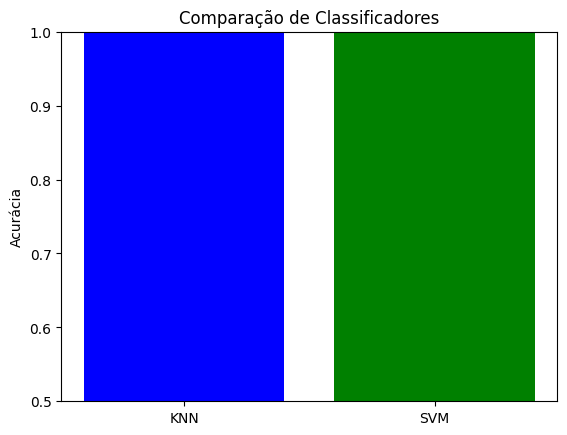

In [ ]:
# Plotando comparação de classificadores
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green'])
plt.title("Comparação de Classificadores")
plt.ylabel("Acurácia")
plt.ylim(0.5, 1.0)
plt.show()

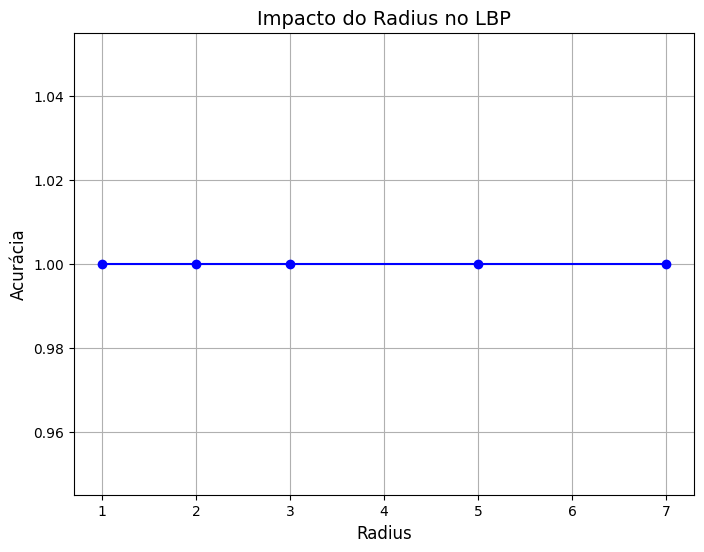

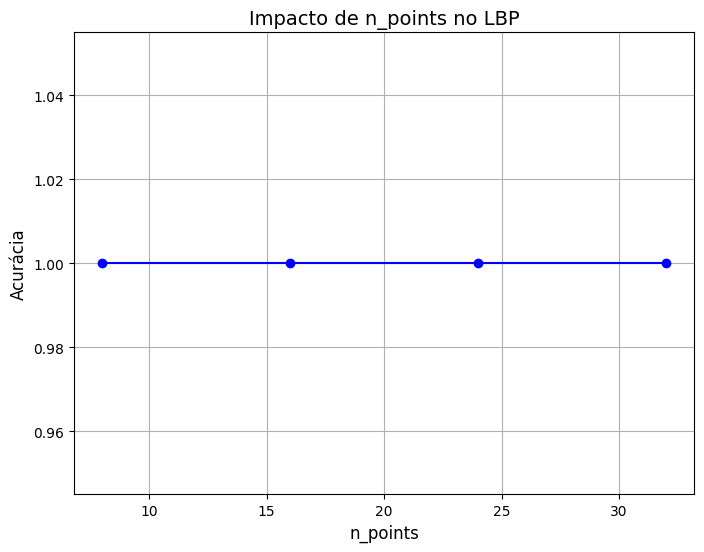

In [ ]:
# Avaliando impacto de radius e n_points
radius_values = [1, 2, 3, 5, 7]
n_points_values = [8, 16, 24, 32]
accuracy_radius, accuracy_n_points = [], []

for radius in radius_values:
    lbp_train = extract_lbp_features(X_train, radius=radius, n_points=8 * radius)
    lbp_test = extract_lbp_features(X_test, radius=radius, n_points=8 * radius)
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(lbp_train, y_train)
    acc = accuracy_score(y_test, knn.predict(lbp_test))
    accuracy_radius.append(acc)

for n_points in n_points_values:
    lbp_train = extract_lbp_features(X_train, radius=3, n_points=n_points)
    lbp_test = extract_lbp_features(X_test, radius=3, n_points=n_points)
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(lbp_train, y_train)
    acc = accuracy_score(y_test, knn.predict(lbp_test))
    accuracy_n_points.append(acc)

plot_impact(radius_values, accuracy_radius, "Impacto do Radius no LBP", "Radius", "Acurácia")
plot_impact(n_points_values, accuracy_n_points, "Impacto de n_points no LBP", "n_points", "Acurácia")

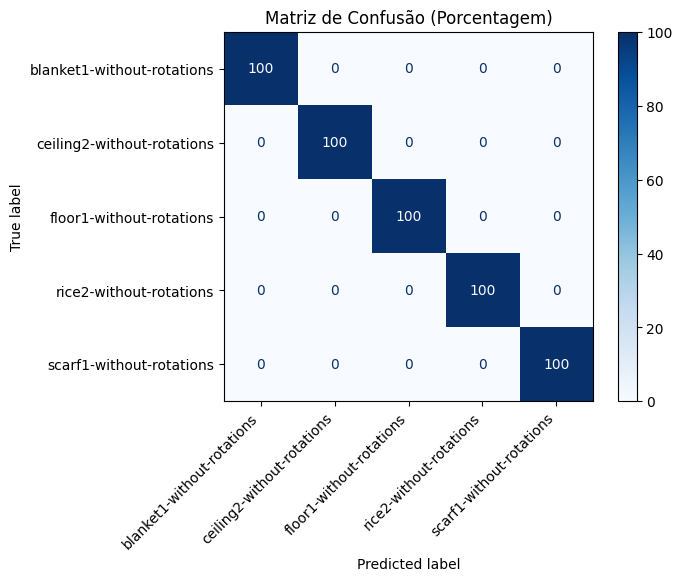

In [ ]:
# Matriz de confusão para o melhor modelo
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.xticks(rotation=45, ha='right')
plt.title("Matriz de Confusão (Porcentagem)")
plt.show()


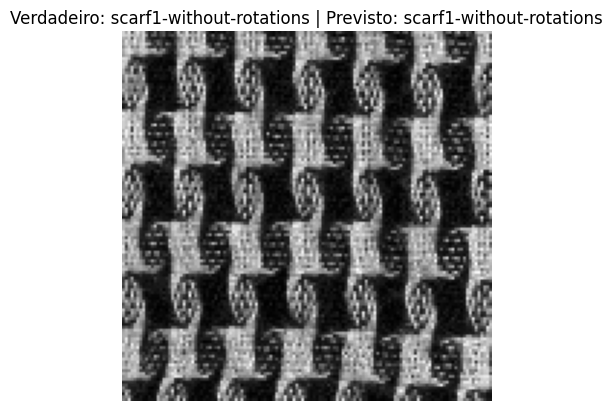

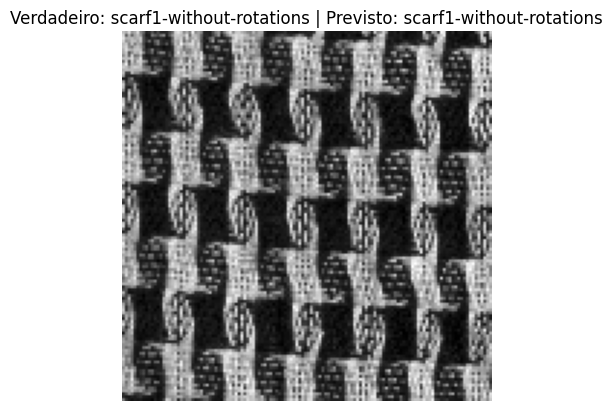

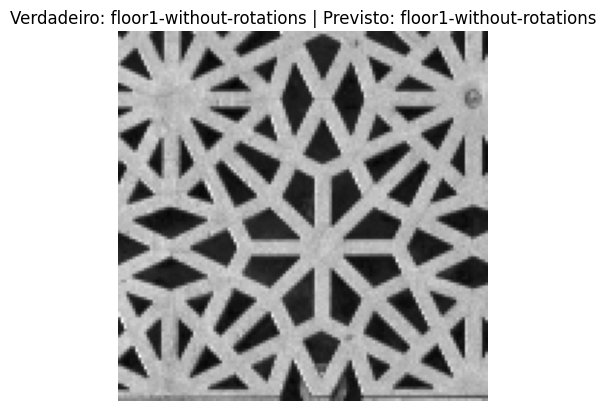

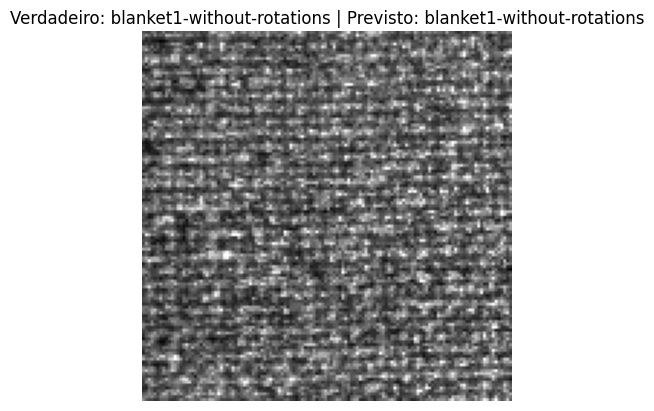

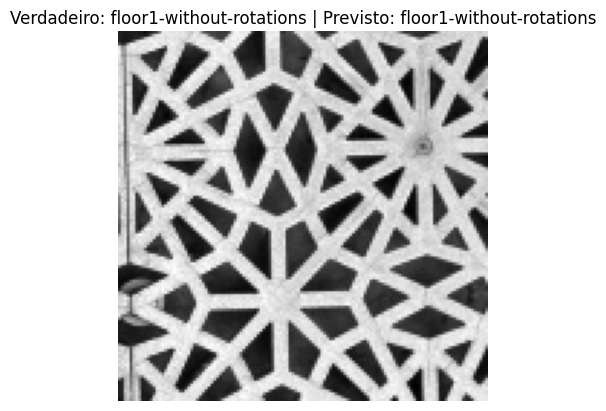

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):  # Mostre 5 exemplos
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Verdadeiro: {le.inverse_transform([y_test[i]])[0]} | Previsto: {le.inverse_transform([y_pred[i]])[0]}")
    plt.axis('off')
    plt.show()


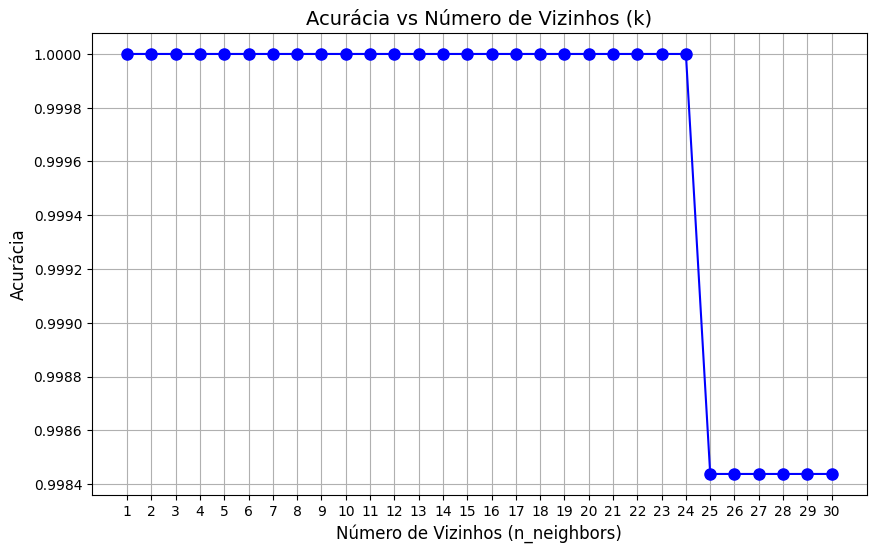

In [ ]:

results = grid_search.cv_results_

k_values = results['param_n_neighbors'].data
accuracies = results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', color='b', linestyle='-', markersize=8)
plt.title('Acurácia vs Número de Vizinhos (k)', fontsize=14)
plt.xlabel('Número de Vizinhos (n_neighbors)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(1, 31, 1))
plt.show()
